# Going Deeper~ 1 resnet구현해보기  
----  
목차  
1. 전처리
 - 이미지 사이즈 변환    
2. resnet 모델  
 - resblock 구축  
 - plain_model, resnet_model 생성
3. 그래프  
4. 여러가지 변경점  
5. 회고

### 1. 전처리  
----  
필요한 라이브러리를 불러옵니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models, layers

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
dataset, ds_info = tfds.load(name='cats_vs_dogs', split=tfds.Split.TRAIN, with_info=True)

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train,ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ['train[:80%]' , 'train[80%:]'],
    as_supervised = True,
    shuffle_files=True,
    with_info=True
)


 - Data를 load 하고 split하여 train data와 validation data를 나눠주고, as_supervised = True로 해서 data를 tuple형태로 받아옵니다.

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


 - split하여 train과 validation을 나눈 것을 확인.

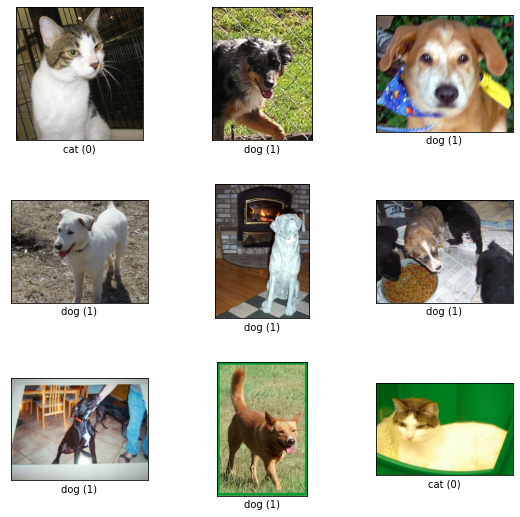

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

 - data image 확인

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

 - image를 resizing하고 batch해주는 함수

In [8]:
BATCH_SIZE = 64
EPOCH = 15
ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

In [9]:
ds_info.features["label"].num_classes

2

In [10]:
ds_info.features["label"].names

['cat', 'dog']

In [11]:
ds_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

### 2. 모델 생성  
----  
 - res block 만들기.

In [12]:
  def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

 - identity를 정의하여 layer 진행 후 x와 add 해줌으로써 skip connection을 구현.

 - 모델 생성 함수


In [13]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=1,is_50 = False, is_plain = False, activation = 'softmax'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = num_classes
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation=activation, name=f'predictions_{activation}')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

 - 각 모델들의 summary activation함수는 sigmoid를 사용하였고, optimizer는 Adam에 lr = 0.01로 진행하였음.

In [16]:
plain_resnet_34 = build_resnet(is_50 = False, num_classes = 1, is_plain = True, activation = 'sigmoid')

plain_resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 112, 112, 64  832         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 112, 112, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                                           

In [17]:
plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
resnet_34 = build_resnet(is_50 = False,num_classes = 1, activation = 'sigmoid')

resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
plain_resnet_50 = build_resnet(is_50 = True, num_classes = 1 ,is_plain = True, activation = 'sigmoid')

plain_resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 112, 112, 64  832         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_51 (BatchN  (None, 112, 112, 64  256        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

In [21]:
plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
resnet_50 = build_resnet(num_classes = 1,is_50 = True, activation = 'sigmoid')

resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 112, 112, 64  256        ['conv2d_8[0][0]']               
 ormalization)                  )                                                           

In [19]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 103s 246ms/step - loss: 28.7456 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.4867
Epoch 2/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6935 - val_accuracy: 0.4946
Epoch 3/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6934 - val_accuracy: 0.4957
Epoch 4/15
290/290 [==============================] - 66s 226ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6930 - val_accuracy: 0.5124
Epoch 5/15
290/290 [==============================] - 67s 230ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 232.7050 - val_accuracy: 0.4842
Epoch 6/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.4976 - val_loss: 2936954945536.0000 - val_accuracy: 0.4884
Epoch 7/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.4991 - val_loss:

In [23]:
history_34_plain = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 85s 228ms/step - loss: 54.3468 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.4837
Epoch 2/15
290/290 [==============================] - 65s 226ms/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.6930 - val_accuracy: 0.5130
Epoch 3/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 4/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.4991 - val_loss: 9433.3252 - val_accuracy: 0.4861
Epoch 5/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.5035 - val_loss: 3.1278 - val_accuracy: 0.5122
Epoch 6/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.4962 - val_loss: 95679824.0000 - val_accuracy: 0.4924
Epoch 7/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 7824

In [25]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 86s 237ms/step - loss: 39.0619 - accuracy: 0.5021 - val_loss: 0.6939 - val_accuracy: 0.5183
Epoch 2/15
290/290 [==============================] - 70s 241ms/step - loss: 0.6863 - accuracy: 0.5501 - val_loss: 0.6791 - val_accuracy: 0.5812
Epoch 3/15
290/290 [==============================] - 66s 229ms/step - loss: 0.6788 - accuracy: 0.5713 - val_loss: 0.6644 - val_accuracy: 0.6146
Epoch 4/15
290/290 [==============================] - 66s 229ms/step - loss: 0.6937 - accuracy: 0.4990 - val_loss: 0.7044 - val_accuracy: 0.4810
Epoch 5/15
290/290 [==============================] - 66s 229ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 22078.2539 - val_accuracy: 0.5070
Epoch 6/15
290/290 [==============================] - 66s 228ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 1839785856.0000 - val_accuracy: 0.4918
Epoch 7/15
290/290 [==============================] - 66s 228ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0

In [26]:
history_50_plain = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 85s 229ms/step - loss: 38.0080 - accuracy: 0.5030 - val_loss: 0.6934 - val_accuracy: 0.4861
Epoch 2/15
290/290 [==============================] - 66s 228ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5054
Epoch 3/15
290/290 [==============================] - 66s 228ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 249252724736.0000 - val_accuracy: 0.4888
Epoch 4/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6933 - accuracy: 0.4981 - val_loss: 7178844561735680.0000 - val_accuracy: 0.4891
Epoch 5/15
290/290 [==============================] - 66s 228ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 14866124980224103817412608.0000 - val_accuracy: 0.5164
Epoch 6/15
290/290 [==============================] - 66s 227ms/step - loss: 0.6934 - accuracy: 0.4961 - val_loss: 166902985985687418688241664.0000 - val_accuracy: 0.5122
Epoch 7/15
290/290 [==============================] 

### 3. 그래프  
----  
 - 여기서 실수한게 있는데 **모델이름을 잘못적은 그래프**가 있음. 표시해두도록 하겠습니다.

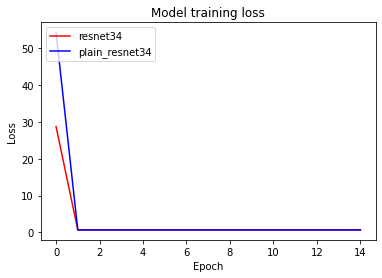

In [27]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

 - 아래 그래프가 **resnet34**의 그래프인데 실수로 50이라고 적음. 헷갈렸습니다. 

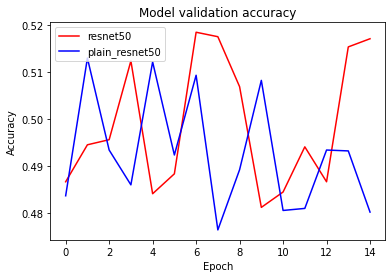

In [31]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 아래 그래프는 **resnet50**인데 34로 잘못 적어둠..

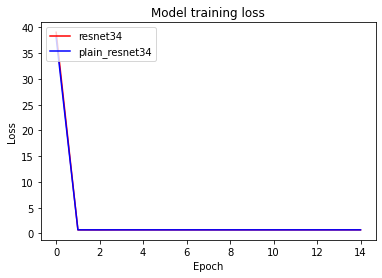

In [32]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

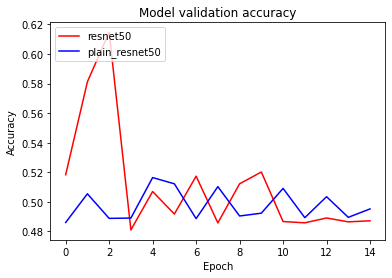

In [30]:
 plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 1차 시도에서는 plain_model이 더 좋은 성능을 보였음. 그냥 그랬나보다 하고 넘어갈 수도 있었지만 model을 다시 확인해보니 conv2D.layer에 activation이 들어가있었고, bn이후에 activation이 없었음. 기존에 배운 resnet_model의 방식과 다르다고 생각하여 수정 후 2회차 진행해보았음.

### 4. 여러가지 변경점  
----  
 - conv2D layer에서 actvation을 빼고 bn 이후에 actvation layer 추가
 - skip connection 진행 후 activation layer 추가
 - identity_channel이 channel과 맞지않을때 (1,1)conv진행 후 bn 해줌

In [ ]:
   def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization(momentum=0.9)(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization(momentum=0.9)(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity) 
                    identity = keras.layers.BatchNormalization(momentum=0.9)(identity)
                # skip connection
                x = keras.layers.Add()([x,identity])
                x = keras.layers.Activation('relu')(x)   
            else:
                x = keras.layers.Activation('relu')(x)
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                identity = keras.layers.BatchNormalization(momentum=0.9)(identity)
            # skip connection
            x = keras.layers.Add()([x,identity]) 
            x = keras.layers.Activation('relu')(x)
        else:
            x = keras.layers.Activation('relu')(x)
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

# 여기도 마찬가지로 그래프의 이름이 바뀌어 있습니다 유의!

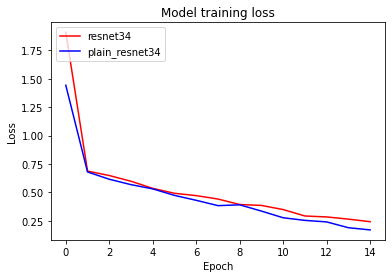

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

 - 이 녀석과

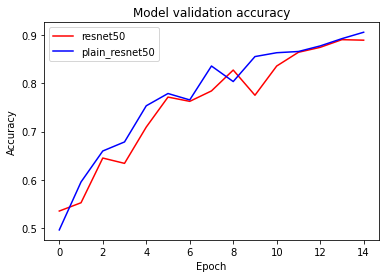

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 이 녀석의 이름이 서로 바뀌어 있습니다.

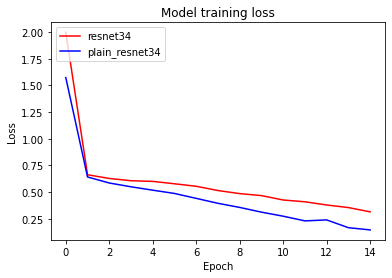

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

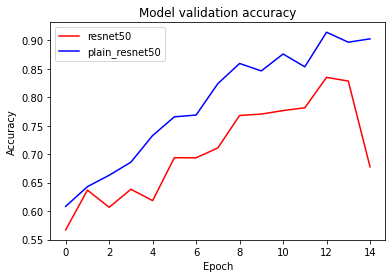

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 이번엔 오히려 노골적으로 plain 모델의 성능이 좋았음. 곰곰히 생각해본 결과 아까 위에서 설명했던 identity channel과 channel이 다를때만 identity에 bn을 해주는다는게 말이 안된다는 생각이 들었음. 그래서 바로 3차시기 달려

### 3차 변경점  
----  
 - identity에 bn을 해줌.

In [ ]:
   def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization(momentum=0.9)(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization(momentum=0.9)(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity) 
                #바로 여기가 변경점
                identity = keras.layers.BatchNormalization(momentum=0.9)(identity)
                # skip connection
                x = keras.layers.Add()([x,identity])
                x = keras.layers.Activation('relu')(x)   
            else:
                x = keras.layers.Activation('relu')(x)
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            identity = keras.layers.BatchNormalization(momentum=0.9)(identity)
            # skip connection
            x = keras.layers.Add()([x,identity]) 
            x = keras.layers.Activation('relu')(x)
        else:
            x = keras.layers.Activation('relu')(x)
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

### 그래프  
----  
 - 이번엔 이름을 바꿔뒀습니다.

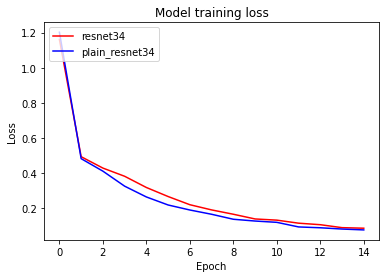

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

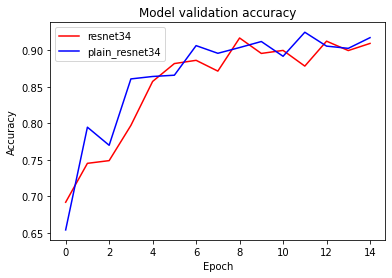

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

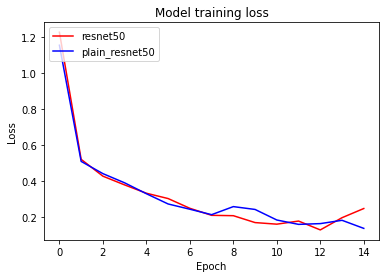

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

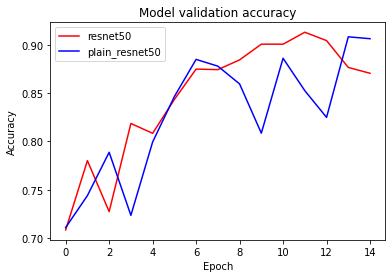

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 드디어 resnet모델이 plain모델과 성능이 유사하게 나옴. 그리고 그래프를 보면 accuracy의 경우 plain모델에 비해 안정적으로 상대적으로 진행되는 것을 볼 수 있었음. 이대로 끝낼까 하다가 globalaveragepooling을 써보면 또 어떤결과가 나올까? lr을 바꾸면?? 이라는 생각이 들어서 찐막 트라이 하기로 했음.

### 찐막 트라이  
----

In [ ]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=1,is_50 = False, is_plain = False, activation = 'softmax'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = num_classes
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization(momentum=0.9)(output)
    output = keras.layers.Activation('relu')(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    #여기가 변경점임 여기 여기
    output = tf.keras.layers.GlobalAveragePooling2D()(output)
    # output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    # output = keras.layers.Dense(512, activation='relu', name='fc2')(output)    
    output = keras.layers.Dense(num_classes, activation=activation, name=f'predictions_{activation}_class_{num_classes}')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 - 다 가져오기 귀찮아서 예시로 하나만 가져옴 lr을 0.002로 변경.

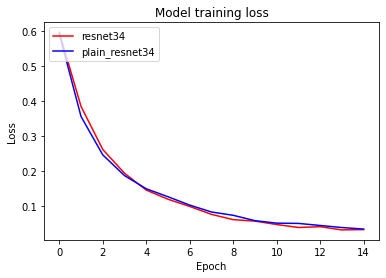

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

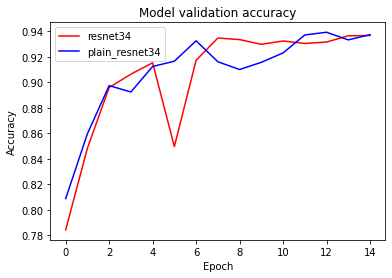

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_resnet34'], loc='upper left')
plt.show()

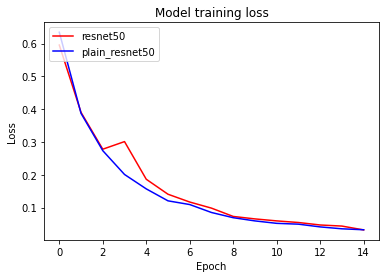

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

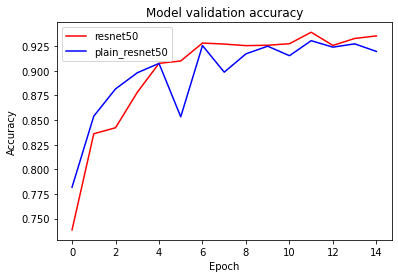

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_resnet50'], loc='upper left')
plt.show()

 - 드디어 resnet모델이 plain모델보다 성능이 뛰어난 상황을 보게 됨. 사실 epoch가 겨우 15라 단정지을 수는 없는 일이지만 그래도 만족스러운 결과였음.

## 회고  
----  
 - 정말 진행하면서 화가 머리끝까지 났었고, 본인의 무능력함에 굉장히 슬펐던 노드. 수 차례 퍼실분들을 찾아가 질문하고 진행하였음. 전처리만 하루 꼬박 했던 것 같음.  
 모델 구현도 최대한 내 손으로 해보고 싶었으나, 구현에 실패하여 이건 진짜 도저히 능력 밖이라 결국 모델의 뼈대는 직접 짜지 못했음.  
 교육생에게 패배감만 안겨주는 노드가 아니였나 하는 생각을 하게 됨. 덕분에 스스로의 위치를 다시한번 깨닫게 되었습니다..  
 정말 머리 터지면서 배운 덕에 쉽게 잊지는 않을 것 같은 resnet 모델이였습니다.  
 아 참 [링크](https://hwanny-yy.tistory.com/12) 올리고 이만 마치도록 하겠습니다. 짝짝짝~  
 (이 분도 AIFFEL 수료생이였나봄 ㅋㅋ)